In [129]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 110) #default tutorial parameters

levels = 2

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs))
n_op_energy_basis = qt.Qobj(n_op_energy_basis)

H0 = qt.Qobj(np.diag(evals))

A = 0.1 # also defined above
drive_op = n_op_energy_basis
# drive_op = n_op_energy   # this is the one that works  
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-2.58495860e-18j 0.-5.66262318e-02j]
 [0.+5.66262318e-02j 0.+6.77105762e-18j]]

In [143]:
is_hermitian = drive_op.isherm
print("drive_op is Hermitian:", is_hermitian)

drive_op is Hermitian: True


In [131]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]]

In [132]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

In [133]:
times = np.linspace(0, 3000, 10000)

options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)

result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.0
    run time: 0.387326717376709
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 3000.0] (10000 steps)
  Number of e_ops: 2
  States saved.
>

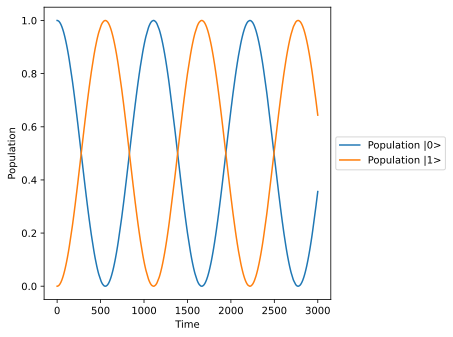

In [134]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [135]:
d01 = abs(n_op_energy[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

554.7945810895415

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

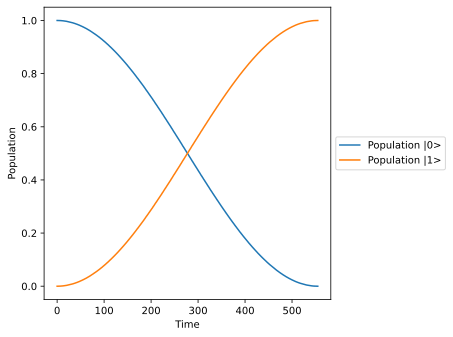

In [136]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Propagator

In [137]:
U = qt.propagator(H, tx, args=args, options=options)

## Fidelity

In [138]:
X_ideal = qt.qeye(levels)
X_ideal = X_ideal.full()

X_ideal[0, 0] = 0
X_ideal[1, 1] = 0
X_ideal[0, 1] = 1
X_ideal[1, 0] = 1

X_ideal = qt.Qobj(X_ideal)

X_ideal

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

In [139]:
#redefine the Hamiltonian with the correct drive amplitude

n_op_energy_basis = fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs))
n_op_energy_basis = qt.Qobj(n_op_energy_basis)
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

In [140]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 4.53102501e-04-2.01976264e-04j  9.88104515e-01+1.53006709e-01j]
 [-5.61132483e-01+8.27584011e-01j  3.92910170e-04-8.83241660e-05j]]

In [141]:
fidelity = qt.fidelity(U, X_ideal)

print("State gate fidelity:", fidelity)

fidelity = qt.average_gate_fidelity(U, X_ideal)

print("Average gate fidelity:", fidelity)

State gate fidelity: 0.9969918566702555
Average gate fidelity: 0.5239772124086528


## Plotting sanity check

(<Figure size 640x480 with 2 Axes>, <Axes3D: >)

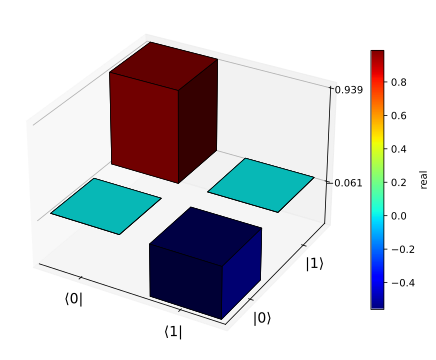

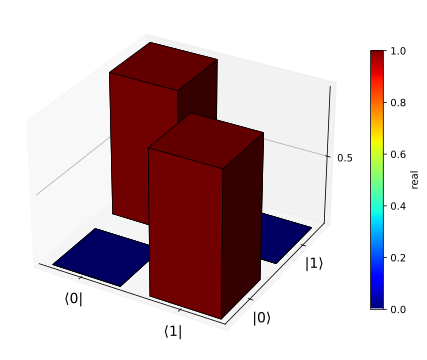

In [142]:
from qutip.visualization import matrix_histogram

matrix_histogram(U)         # For the propagator
matrix_histogram(X_ideal)   # For the ideal gate
